In [62]:
import dgl
import torch
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import networkx as nx   # For visualization
import matplotlib.pyplot as plt  # For visualization


In [63]:
dominos_data = pd.read_excel('dominos_blr.xlsx')
pizzahut_data = pd.read_excel('pizzahut_blr.xlsx')
malls_data = pd.read_excel('malls_blr.xlsx')

In [64]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon1 - lon2
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    
    # Earth radius in kilometers (mean radius)
    earth_radius_km = 6371.0
    
    # Calculate the distance
    distance = earth_radius_km * c
    return distance

In [65]:
g = dgl.DGLGraph()
node_offset = 0  # We'll keep track of node offsets

C:\Users\aparn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [66]:
dominos_coords = dominos_data[['Latitude', 'Longitude']].values
pizzahut_coords = pizzahut_data[['Latitude', 'Longitude']].values
malls_coords = malls_data[['Latitude', 'Longitude']].values


In [67]:
# Add nodes to the graph
g.add_nodes(len(dominos_data) + len(pizzahut_data) + len(malls_data))

# Define the thresholds for the distances
# Set a reasonable threshold distance (in kilometers) for connecting nodes
threshold_distance = 5.0  # Adjust based on your use case

In [68]:
# Function to add edges based on distances
def add_edges_based_on_distances(coords1, coords2, node_type1, node_type2, edge_data_key):
    # Iterate through the nodes and calculate distances
    for i, coord1 in enumerate(coords1):
        for j, coord2 in enumerate(coords2):
            distance = haversine_distance(coord1[0], coord1[1], coord2[0], coord2[1])
            # Add an edge if the distance is within the threshold
            if distance <= threshold_distance:
                src_node = i + node_type1
                dst_node = j + node_type2
                g.add_edges(src_node, dst_node)
                # Store the distance as an edge feature
                g.edata[edge_data_key] = torch.tensor(distance)

In [69]:
def find_nearest_nodes(datapoint, data, threshold, color):
  """
  This function finds nearest nodes (competitors or malls) within a threshold distance
  for a given datapoint (Domino's outlet).
  """
  nearest_nodes = []
  for index, row in data.iterrows():
    distance = haversine_distance(datapoint["Latitude"], datapoint["Longitude"], row["Latitude"], row["Longitude"])
    if distance <= threshold:
      # Add details to a dictionary along with distance and color for visualization later
      nearest_nodes.append({"id": row["id"], "distance": distance})
  return nearest_nodes

In [82]:
nearest_nodes=[]
nearest_competitors=[]
nearest_malls=[]
for index, row in dominos_data.iterrows():
    nearest_nodes.append(find_nearest_nodes(row, dominos_data, 5, "blue"))
    nearest_competitors.append(find_nearest_nodes(row, pizzahut_data, 5, "green"))
    nearest_malls.append(find_nearest_nodes(row, malls_data, 5, "yellow"))

dominos_data["blue_nodes"] = nearest_nodes
dominos_data["yellow_nodes"] = nearest_malls
dominos_data["green_data"] = nearest_competitors

dominos_data['id'] = dominos_data['id'].astype(str)

dominos_data.to_excel("dominos_updated.xlsx")

In [90]:
# Add blue nodes (Domino's outlets)
num_blue_nodes = len(dominos_data)
g.add_nodes(num_blue_nodes)
g.ndata['node_type'] = torch.empty(g.number_of_nodes(), dtype=torch.int64)
g.ndata['node_type'][:num_blue_nodes] = 0  # Set node type to 0 for blue node

# Add green nodes (Pizza Hut outlets)
num_green_nodes = len(pizzahut_data)
g.add_nodes(num_green_nodes)
g.ndata['node_type'][num_blue_nodes:num_blue_nodes + num_green_nodes] = 1 

# Add yellow nodes (Shopping malls)
num_yellow_nodes = len(malls_data)
g.add_nodes(num_yellow_nodes)
g.ndata['node_type'][num_blue_nodes + num_green_nodes:] = 2 


In [91]:
def add_edges_based_on_distances(coords1, coords2, node_type1, node_type2, edge_data_key):
    scores = []
    src_nodes = []
    dst_nodes = []
    # Iterate through the nodes and calculate distances
    for i, coord1 in enumerate(coords1):
        for j, coord2 in enumerate(coords2):
            distance = haversine_distance(coord1[0], coord1[1], coord2[0], coord2[1])
            # Add an edge if the distance is within the threshold
            if distance <= threshold_distance:
                src_node = i + node_type1
                dst_node = j + node_type2
                g.add_edges([src_node], [dst_node])
                #g.edata[edge_data_key] = torch.tensor([distance], dtype=torch.float)
                # src_nodes.append(src_node)
                # dst_nodes.append(dst_node)
                # scores.append(distance)
    
    # Add edges to the graph
    # g.add_edges(src_nodes, dst_nodes)
    # # Store the distance as an edge feature
    # scores_tensor = torch.tensor(scores, dtype=torch.float).to(g.device)
    # g.edata[edge_data_key] = scores_tensor

In [92]:
# Define threshold distance for connecting nodes
threshold_distance = 5.0  # Adjust based on your use case

# Add edges between different node types

# Add edges between dominos outlets (blue nodes)
add_edges_based_on_distances(dominos_coords, dominos_coords, 0, 0, 'blue_distance')

# Add edges between dominos outlets and shopping malls (yellow nodes)
add_edges_based_on_distances(dominos_coords, malls_coords, 0, len(dominos_data), 'yellow_distance')

# Add edges between dominos outlets and pizzahut outlets (green nodes)
add_edges_based_on_distances(dominos_coords, pizzahut_coords, 0, len(dominos_data) + len(malls_data), 'green_distance')


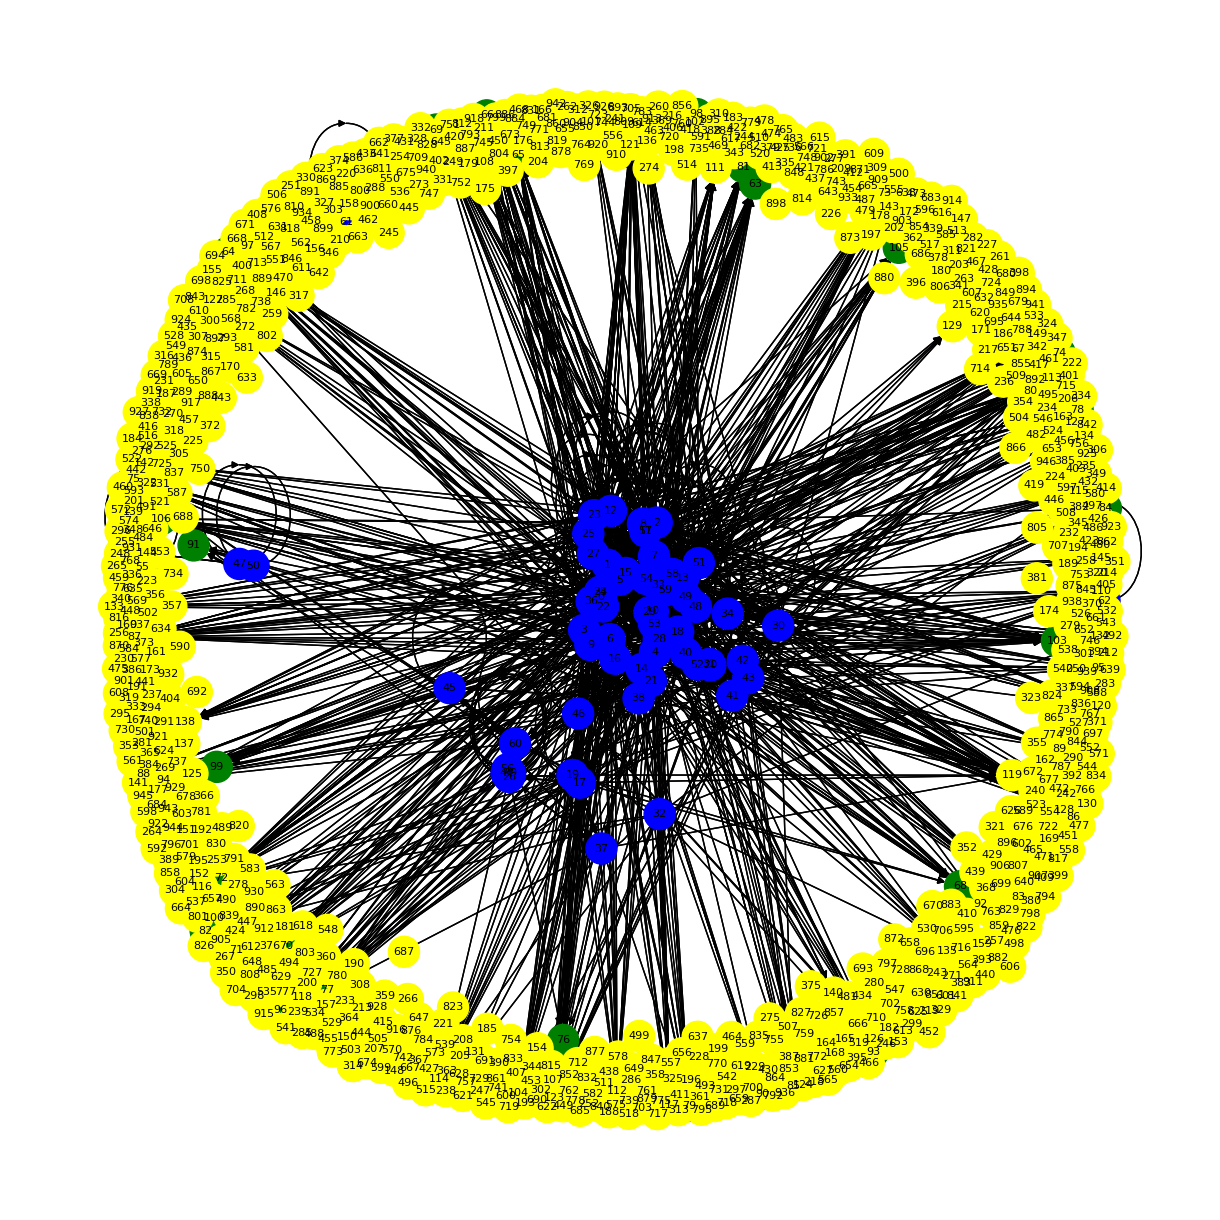

In [93]:
# Convert the DGL graph to a NetworkX graph
nx_graph = dgl.to_networkx(g, node_attrs=['node_type'])

# Define node color mapping based on node type
node_color_mapping = {
    0: 'blue',   # Blue nodes (Domino's outlets)
    1: 'green',  # Green nodes (Pizza Hut outlets)
    2: 'yellow'  # Yellow nodes (Shopping malls)
}

# Get the list of node types and colors for visualization
node_types = nx.get_node_attributes(nx_graph, 'node_type')
node_types = {node: int(node_type) for node, node_type in node_types.items()}
node_colors = [node_color_mapping[node_types[node]] for node in nx_graph.nodes]

# Visualize the graph
plt.figure(figsize=(12, 12))

# Draw the graph using spring layout for better visualization
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=8)

# Optional: Draw edges with different colors based on edge type (if desired)
# Uncomment and customize the following lines as needed to visualize edges differently

# nx.draw_networkx_edges(nx_graph, pos, edgelist=[(u, v) for u, v, d in nx_graph.edges(data=True) if 'blue_distance_score' in d], edge_color='blue')
# nx.draw_networkx_edges(nx_graph, pos, edgelist=[(u, v) for u, v, d in nx_graph.edges(data=True) if 'yellow_distance_score' in d], edge_color='yellow')
# nx.draw_networkx_edges(nx_graph, pos, edgelist=[(u, v) for u, v, d in nx_graph.edges(data=True) if 'green_distance_score' in d], edge_color='green')

# Show the graph
plt.show()

In [150]:
# Define message passing functions

# Blue node (Domino's outlets) message passing
# def blue_message_func(edges):
#     # Count the number of blue nodes connected to each blue node
#     return {'blue_score': torch.tensor(torch.ones_like(edges.src))}

# Blue node (Domino's outlets) message passing
def blue_message_func(edges):
    # Count the number of blue nodes connected to each blue node
    return {'blue_score': torch.ones_like(edges.src['node_type'], dtype=torch.int64)}

# Yellow node (Shopping malls) message passing
def yellow_message_func(edges):
    # Count the number of yellow nodes connected to each blue node
    return {'yellow_msg': torch.ones_like(edges.src['node_type'], dtype=torch.int64)}

# Green node (Pizza Hut outlets) message passing
def green_message_func(edges):
    # Count the number of green nodes connected to each blue node
    return {'green_msg': torch.ones_like(edges.src['node_type'], dtype=torch.int64)}

In [151]:
number = g.number_of_nodes()
# Assign node features
g.ndata['blue_features'] = torch.tensor([-10]*947, dtype=torch.float)
g.ndata['green_features'] = torch.tensor([5]*947, dtype=torch.float)
g.ndata['yellow_features'] = torch.tensor([5]*947, dtype=torch.float)

In [152]:
# Define a simple GCN model
class GCNModel(torch.nn.Module):
    def _init_(self):
        super(GCNModel, self)._init_()
        # Add GCN layers or other additional operations as needed

    def forward(self, g, features):
        # Define the forward pass
        
        # Perform message passing and aggregation
        # Update the blue node scores based on connections
        g.update_all(blue_message_func, dgl.function.sum('blue_score', 'blue_agg'))
        g.update_all(yellow_message_func, dgl.function.sum('yellow_msg', 'yellow_agg'))
        g.update_all(green_message_func, dgl.function.sum('green_msg', 'green_agg'))
        
        # Combine the aggregated features for final prediction
        combined_features = torch.cat([g.ndata['blue_agg'], g.ndata['yellow_agg'], g.ndata['green_agg']], dim=1)
        
        # Apply any additional layers or operations as needed
        # Return the combined features for predictions
        return combined_features

In [153]:
# Instantiate the GCN model
model = GCNModel()

# Define training parameters
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()  # Change this based on your use case

# Training loop (Illustrative)
num_epochs = 100  # Adjust as needed

In [154]:
for epoch in range(num_epochs):
    # Initialize node features for training
    features = torch.cat([
        g.ndata['blue_features'],  # Domino's outlets
        g.ndata['yellow_features'],  # Shopping malls
        g.ndata['green_features']  # Pizza Hut outlets
    ], dim=0)
    
    # Forward pass
    outputs = model(g, features)
    
    # Define targets based on your use case (e.g., desired distances)
    # Note: You'll need to create a target tensor based on your use case
    targets = ... 
    
    # Calculate the loss
    loss = loss_fn(outputs, targets)
    
    # Backpropagation and optimization
    #optimizer.zero_grad()
    loss.backward()
    #optimizer.step()
    
    # Optionally, print the loss to monitor training progress
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Model training complete

DGLError: [13:41:27] C:\Users\peizhou\workspace\DGL_scripts\release\win-64\dgl\src\array\kernel.cc:43: Check failed: (out->dtype).code == kDGLFloat || (out->dtype.code == kDGLBfloat): Feature data must be float type